# Sentiment analysis using review comments

Let's import some of the required packages

In [1]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import re

Reading the train and test data from Kaggle.

In [2]:
train_file_lines = bz2.BZ2File('input_data/amazon_data/train.ft.txt.bz2').readlines()
test_file_lines = bz2.BZ2File('input_data/amazon_data/test.ft.txt.bz2').readlines()

Convert the data into using utf-8 format.

In [3]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

The data contains labels representing customers' feelings (either positive or negative) about the product. Thus, developing classifier models that can classify given comment as positive or negative can be the best approach for Sentiment Analysis. By observing the data, we can split the data into Sentences and Labels for test and training data.

In [4]:
def form_lables_and_sentences(file_lines):
    labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in file_lines]
    sentences = [x.split(' ', 1)[1][:-1].lower() for x in file_lines]
    return labels, sentences
    
    
train_lables, train_sentences = form_lables_and_sentences(train_file_lines)    
test_lables, test_sentences = form_lables_and_sentences(test_file_lines)

Data pre-processing is essential before developing a model. In Natural Language Processing, we need to clean the sentences to extract useful features from them. To clean the data in text format, we have to remove those symbols, characters, and spacing conventions that convey little or no information. Data cleaning for text comments can be done as follows:

In [5]:
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')

def clean_sentences(sentences):
    for i in range(len(sentences)):
            if 'www.' in sentences[i] or 'http:' in sentences[i] or 'https:' in sentences[i] or '.com' in sentences[i]:
                urls = re.findall("https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+", sentences[i])
                for url in urls:
                    sentences[i] = sentences[i].replace(url, "<url>")
            sentences[i] = re.sub('\d','0',sentences[i])
            sentences[i] = re.sub('\t','',sentences[i])
            sentences[i] = re.sub('\n','',sentences[i])
            sentences[i] = NON_ALPHANUM.sub(r' ', sentences[i])
            sentences[i] = NON_ASCII.sub(r'', sentences[i])
            sentences[i] = sentences[i].strip()
    return sentences
        
train_sentences = clean_sentences(train_sentences)
test_sentences = clean_sentences(test_sentences)

NLTK is a python library that comes with numerous capabilities for humans to process the natural text. 
Getting some of the required packages for classifier design.

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from sklearn.svm import LinearSVC

from nltk.classify import svm
nltk.download('stopwords')

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/z003c93/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Forming a dataframe for training and testing data that will have sentences and corresponding labels.

In [7]:
train_data = pd.DataFrame({'Sentence': train_sentences, 'Label': train_lables})
test_data = pd.DataFrame({'Sentence': test_sentences, 'Label': test_lables})
train_data.head()

,Sentence,Label
0,stuning even for the non gamer this sound tra...,1
1,the best soundtrack ever to anything i m rea...,1
2,amazing this soundtrack is my favorite music...,1
3,excellent soundtrack i truly like this soundt...,1
4,remember pull your jaw off the floor after he...,1


Removing unnecessary variables to clean some memory.

In [8]:
del train_file_lines, test_file_lines
gc.collect()

11

One of the step while cleaning text data in sentiment analysis can be removing stopwords from sentences as they don't really convey significant information in deciding the label.

In [9]:
stopwords_set = set(stopwords.words("english"))


In [10]:
print(stopwords_set)

{'me', 'more', 'ourselves', 'off', 'them', "that'll", 'hers', 'of', "didn't", 'needn', 'own', 'our', 'his', 'about', "isn't", 'wasn', 'few', "hadn't", 'hasn', 'he', 'isn', "you'll", 'but', 'both', 'an', 'not', 'at', 'who', 'when', 're', "shan't", 'ain', 'their', 'each', "needn't", 'too', "mustn't", 'through', 'having', 'yours', 'is', 'so', 'shouldn', 'itself', 'themselves', 'ma', 'haven', 'its', 'than', 'into', 'all', 'the', 'theirs', 'those', 'once', 'hadn', 'did', 'if', 'was', 'to', 'should', 'down', 's', 'mustn', 'then', 'just', 'this', 'doing', 'here', "doesn't", 'on', "she's", 'have', 'no', "it's", 'such', 'and', 'above', 'for', 'that', 'can', "won't", 'doesn', 't', 'ours', 'these', 'aren', 'yourselves', 'd', 've', "shouldn't", "haven't", 'very', 'she', 'there', 'in', "wouldn't", 'until', 'with', 'couldn', 'while', "couldn't", "mightn't", 'it', 'before', "you're", 'same', 'am', 'nor', "you'd", 'they', 'what', 'after', 'over', 'my', 'didn', 'y', 'will', 'because', 'which', 'don', '

From the large dataset we can select 10k rows to train our model. Normally train to test ratio must be maintained near 0.8

In [11]:
labeled_train_featuresets = []
all_fine_tuned_words = []

def remove_stopwords(train_df):
    for index, row in train_df.iterrows():
        words_filtered = [e.lower() for e in row.Sentence.split() if len(e) >= 3]
        words_without_stopwords = [word for word in words_filtered if not word in stopwords_set]
        labeled_train_featuresets.append((words_without_stopwords, row.Label))
        all_fine_tuned_words.extend(words_without_stopwords)
        
remove_stopwords(train_data.head(10000))

Checking if the training set has nearly equal proportions of positive and negative sentences.

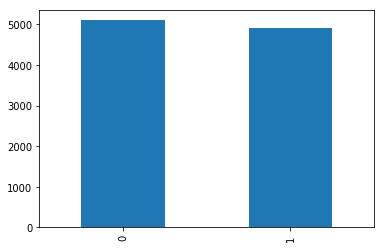

In [12]:
import matplotlib.pyplot as plt
import pandas

fig, ax = plt.subplots()
train_data.head(10000)['Label'].value_counts().plot(ax=ax, kind='bar')

Now we can start building features for our model. To get features from our document we can use Frequency Distribution function provided by ntlk. http://www.nltk.org/api/nltk.html?highlight=freqdist

In [13]:
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

words_features = get_word_features(all_fine_tuned_words)

We can create a feature function that will be used by our classifier model while training the data.

In [14]:
def features_func(document):
    document_words = set(document)
    features = {}
    for word in words_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

NTLK library provides apply_features function that will help in generating our training set data based on the feature extraction function that we want.

In [15]:
training_set = nltk.classify.apply_features(features_func,labeled_train_featuresets)

Naive Bayes classifier can be trained using NB_Classifier

In [16]:
NB_classifier = nltk.NaiveBayesClassifier.train(training_set)

After training the data we can check the most informative features used while training the dataset.

In [17]:
NB_classifier.show_most_informative_features(15)

Most Informative Features
         contains(waste) = True                0 : 1      =     42.6 : 1.0
      contains(pathetic) = True                0 : 1      =     27.3 : 1.0
 contains(disappointing) = True                0 : 1      =     24.0 : 1.0
         contains(awful) = True                0 : 1      =     21.9 : 1.0
          contains(junk) = True                0 : 1      =     21.1 : 1.0
       contains(medical) = True                1 : 0      =     19.8 : 1.0
     contains(defective) = True                0 : 1      =     19.0 : 1.0
         contains(worst) = True                0 : 1      =     18.8 : 1.0
    contains(misleading) = True                0 : 1      =     18.3 : 1.0
contains(disappointment) = True                0 : 1      =     18.0 : 1.0
       contains(higgins) = True                0 : 1      =     16.4 : 1.0
     contains(pointless) = True                0 : 1      =     16.4 : 1.0
    contains(ridiculous) = True                0 : 1      =     16.4 : 1.0

In order to fit other classifiers on our training dataset we can use wrapper classifier- SklearnClassifier provided by NLTK library. This classifier helps in mapping sklearn classifier to natural language processing classifiers. Selecting a few classifiers that might perform better than Naive Bayes classifier.

In [18]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_selection import SelectKBest
# from scipy.stats import chi2
from sklearn.svm import LinearSVC

#get models from sklearn
models_from_sklearn = [('SVM',LinearSVC()),
                       ('LR', LogisticRegression(solver='lbfgs')),  
                       ('DT',DecisionTreeClassifier(criterion='entropy')), 
                       ('RF',RandomForestClassifier(n_estimators=100, criterion='entropy'))]
classifiers_for_comparison = []

for name,model in models_from_sklearn:
    text_classifier = SklearnClassifier(model).train(training_set)
    classifiers_for_comparison.append( (name , text_classifier) )


We can split the test data into five subsets that can be tested independently.

In [19]:
test_subset_one = test_data[:1000]
test_subset_two = test_data[2000:3000]
test_subset_three = test_data[4000:5000]
test_subset_four = test_data[6000:7000]
test_subset_five = test_data[9000:10000]
test_sets_group = [test_subset_one,test_subset_two, test_subset_three,test_subset_four ,test_subset_five]

Once we have our test sets ready, we can use our models for predictions on test sets. F1-score and Accuracy of these models can be compared to select best model.

In [20]:
from sklearn.metrics import f1_score, accuracy_score
models = []
models.append(('NB', NB_classifier))
for name, classifier in classifiers_for_comparison:
    models.append((name,classifier))


In [21]:
results = []
names = []
for name, model in models:
    accuracy_scores = []
    f1_scores = []
    accuracy_scores = []
    for test_data in test_sets_group:
        ground_truth = test_data['Label']
        predictions = []
        for obj in test_data['Sentence']: 
            res =  model.classify(features_func(obj.split()))
            predictions.append(res)
        accuracy = accuracy_score(ground_truth, predictions)
        accuracy_scores.append(accuracy)
        f1_score_value = f1_score(ground_truth, predictions)
        f1_scores.append(f1_score_value)
    print("============================================")
    print("Average F1 score for %s is %0.3f with standard deviation as %0.3f " %(name, np.mean(f1_scores),np.std(f1_scores)))
    print("Average Accuracy for %s is %0.3f with standard deviation as %0.3f  \n" %(name, np.mean(accuracy_scores),np.std(accuracy_scores)))
    results.append(accuracy_scores)
    names.append(name)

Average F1 score for NB is 0.844 with standard deviation as 0.012 
Average Accuracy for NB is 0.840 with standard deviation as 0.017  

Average F1 score for SVM is 0.825 with standard deviation as 0.018 
Average Accuracy for SVM is 0.820 with standard deviation as 0.023  

Average F1 score for LR is 0.847 with standard deviation as 0.016 
Average Accuracy for LR is 0.843 with standard deviation as 0.019  

Average F1 score for DT is 0.735 with standard deviation as 0.011 
Average Accuracy for DT is 0.729 with standard deviation as 0.015  

Average F1 score for RF is 0.840 with standard deviation as 0.013 
Average Accuracy for RF is 0.834 with standard deviation as 0.018  



Visualizing the accuracy obtained for different models using Matplotlib.

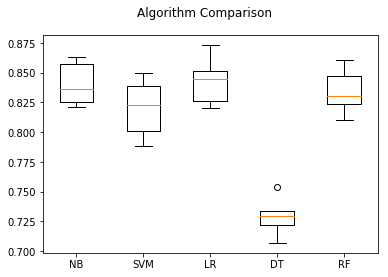

In [22]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In conclusion we can say that, Logistic Regression and Naive Bayes classifier give better results than other models with acceptable standard deviation.